In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import tensorboard
import ot
from statsmodels.distributions.empirical_distribution import ECDF
import Prob_models as PM
import random
import scipy

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

2022-11-30 09:43:17.097881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
seed = 0
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Metrics

## QQplot

NameError: name 'samples_y' is not defined

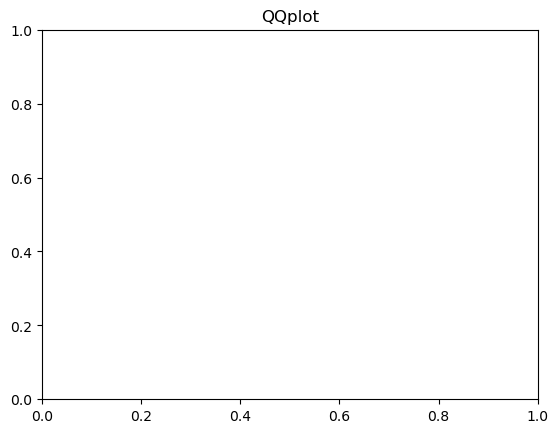

In [4]:
plt.figure()
plt.title('QQplot')
plt.scatter(tf.sort(samples_y),tf.sort(samples_rad))
plt.plot(tf.sort(samples_y),tf.sort(samples_y))

### KL divergence upon a threshold

In [12]:
def tail_mod(f,n,x):
    return((n/n+1)*(1-f(x))+1/(n+1))



def L(X,Y,u):
    Nn = np.sum(X>u)
    m=Y.shape[0]
    fY=ECDF(Y)
    Xmax = np.maximum(X,u)
    Xu = np.minimum(Xmax,u)
    res = 1 + 1/Nn*(np.sum(np.log(tail_mod(fY,m,Xmax)/tail_mod(fY,m,Xu))))
    return(res)
    
def K(X,Y,u):
    res = -L(X,Y,u)-L(Y,X,u)
    return res

### Wasserstein distance

In [8]:
def Wasserstein(s1,s2):
    M=ot.dist(s1,s2)
    return(ot.emd2())

### Threshold selection

In [9]:
def distmat(X):
    r = tf.reduce_sum(X*X, 1)
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(X, tf.transpose(X)) + tf.transpose(r)
    return(tf.maximum(D,0))

def T(X,Y,n):
    MX = tf.math.sqrt(distmat(X))
    MY = tf.math.sqrt(distmat(Y))
    T1 = (1/n**2)*tf.reduce_sum(tf.math.multiply(MX,MY))
    T2 = (2/n**3)*tf.reduce_sum(tf.linalg.matmul(MX,MY))
    T3 = (1/n**4)*tf.reduce_sum(tf.tensordot(MX,MY,axes=0))
    return T1-T2+T3


In [ ]:
#pvalues for given radii sorted R_sort and associated angles angle_dep
nbq = 30
qmax=0.15
qmin=0.4
m=60
L=200
qk = np.arange(qmax,qmin,(qmin-qmax+0.001)/nbq)
nk = 500*qk
res=[]


for i in range(nbq):
    pvi = 0
    for k in range(m):
        q = qk[i]
        n = nk[i]
        r = R1_sort[np.int((1-q)*10000)].numpy()
        Ind = tf.cast(tf.where(R>r),dtype=tf.int32)
        Rq = R[Ind]/r
        angle = angle_dep[Ind]
        IndS = np.random.permutation(Ind[0])[:np.int(n)]
        RqS_joint = (R[IndS]/r)
        shape_RqS=RqS_joint.shape[0]
        RqS_joint = tf.reshape(RqS_joint,(shape_RqS,1))
        angleS_joint = (angle_dep[IndS])
        T_emp = T(RqS_joint,angleS_joint,np.int(n))
        pvk=0
        for j in range(L):
            RqS_ind=np.random.permutation(Rq)[:np.int(n)]
            RqS_ind = np.expand_dims(RqS_ind,axis=-1)
            angleS_ind = np.random.permutation(angle)[:np.int(n)]
            T_ind = T(RqS_ind,angleS_ind,np.int(n))
            pvk+= T_emp.numpy()>(T_ind.numpy())
        pvk = pvk/L
        pvi+=pvk
    pvi = pvi/m
    res.append(pvi)

# Radius experiment

In [57]:
checkpoint_path = '/home/nlafon/These/Extreme_VAE/tmp/radius1/Ext_VAE/Gamma_output9/Ext_VAE_custom_outputG_fig3'
import Prob_models as PM
#vae_test = PM.Std_VAE()
vae_test = PM.Ext_VAE()
#vae_test = PM.U_Ext_VAE()
#vae_test = PM.Ext_Multi_VAE()
vae_test.load_weights(checkpoint_path)

In [58]:
print(vae_test.encoder.prior.concentration)

tf.Tensor(1.5, shape=(), dtype=float32)


In [59]:
# Samples from R1
N_samples = 10000
A = 2*tfd.Uniform().sample(N_samples)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(N_samples)
test_set = A*X
test_set =test_set.numpy()

In [43]:
# Samples from R2
N_samples = 10000
Ber = tfd.Bernoulli(probs=0.3, dtype ='float').sample(N_samples) 
IG1 = tfd.InverseGamma(concentration =1.8, scale = 1 ).sample(N_samples)
IG2 = tfd.InverseGamma(concentration =1.8, scale = 1 ).sample(N_samples)
R2 = IG1*Ber +(6+IG2)*(1-Ber)

test_set = R2.numpy()

In [60]:
prior_samples = vae_test.encoder.prior.sample(N_samples)
print(tf.reduce_max(prior_samples))
print(tf.reduce_min(prior_samples))
samples_vae = vae_test.decoder(prior_samples).sample()
print(samples_vae)

tf.Tensor(10.019894, shape=(), dtype=float32)
tf.Tensor(0.0010671582, shape=(), dtype=float32)
tf.Tensor([0.6529276  1.7460274  0.25876743 ... 0.80851454 0.18843234 1.4169549 ], shape=(10000,), dtype=float32)


In [61]:
print(tf.reduce_max(samples_vae))
print(tf.reduce_min(samples_vae))
print(tf.reduce_max(test_set))
print(samples_vae.shape)

tf.Tensor(451.76636, shape=(), dtype=float32)
tf.Tensor(3.0028434e-07, shape=(), dtype=float32)
tf.Tensor(139.19626, shape=(), dtype=float32)
(10000,)


/tmp/ipykernel_63827/2358292155.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_vae)


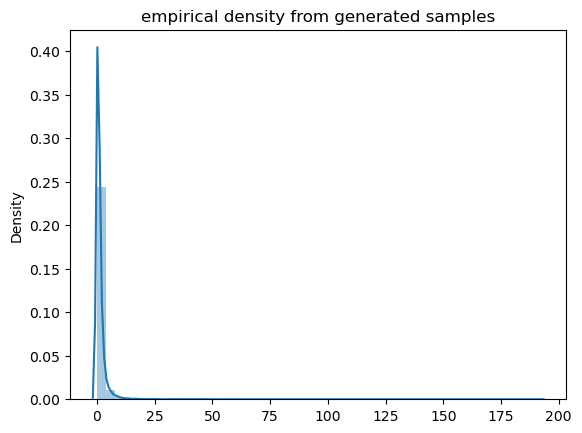

/tmp/ipykernel_63827/2358292155.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_set)


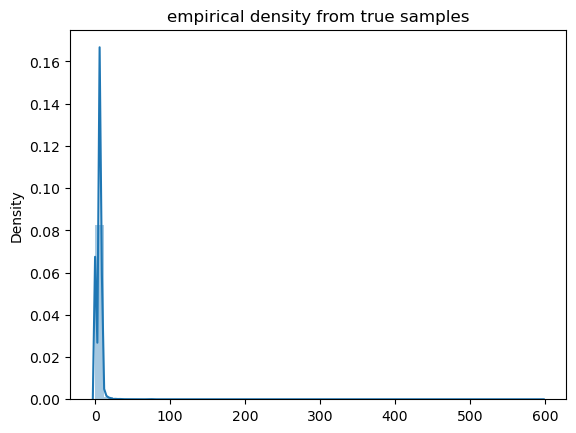

In [50]:
sns.distplot(samples_vae)
plt.title("empirical density from generated samples")
plt.show()

sns.distplot(test_set)
plt.title("empirical density from true samples")
plt.show()


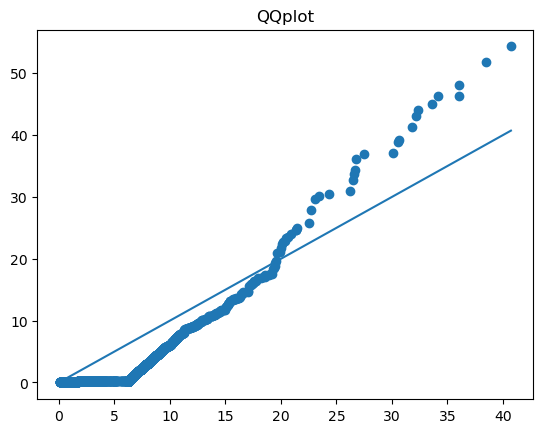

In [51]:
plt.figure()
plt.title('QQplot')
plt.scatter(tf.sort(test_set)[:9992],tf.sort(samples_vae)[:9992])
plt.plot(tf.sort(test_set)[:9992],tf.sort(test_set)[:9992])

(10000,)


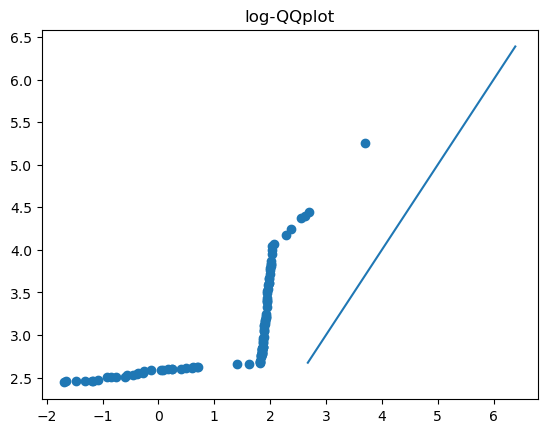

In [55]:
print(samples_vae.shape)
plt.figure()
plt.title('log-QQplot')
plt.scatter(tf.math.log(tf.sort(test_set[9900:])),tf.math.log(tf.sort(samples_vae)[9900:]))
plt.plot(tf.math.log(tf.sort(test_set)[9900:]),tf.math.log(tf.sort(test_set)[9992:]))

tf.Tensor(2.1687765, shape=(), dtype=float32)
KL divergence upon threshold 0.9 :  0.7394601448538084


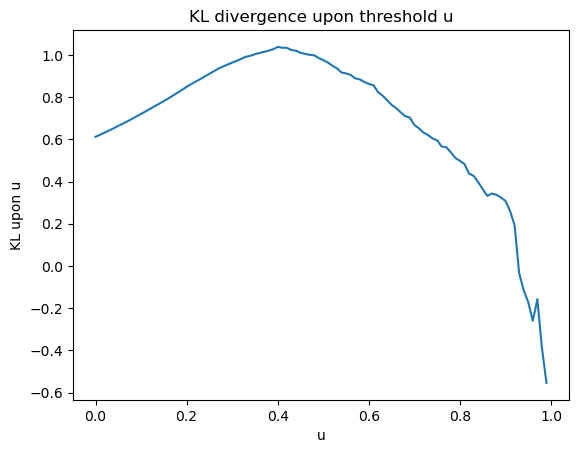

In [28]:
#Kl divergence upon a threshold
q = 0.9
u=tf.sort(test_set)[int(q*N_samples)]
print(u)
print(f"KL divergence upon threshold {q} :  {K(test_set,samples_vae,u)}")

X = np.arange(0,1,0.01)
Ind = X*10000
Ind = Ind.astype('int64')

Q = np.sort(samples_vae)[Ind]
#Q = np.sort(test_set)[Ind]

Y = [K(test_set,samples_vae,qi) for qi in Q]
plt.figure()
plt.title("KL divergence upon threshold u")
plt.xlabel("u")
plt.ylabel("KL upon u")
plt.plot(X,Y)

In [29]:
#vae_score on test set:
data_test = tf.reshape(test_set,(N_samples,1))
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
vae_test.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negative_log_likelihood)
vae_test.evaluate(data_test,data_test,batch_size=32)

313/313 [==============================] - 2s 4ms/step - loss: 1.6537


1.6536592245101929

In [1]:
# Statistical insights in data tail index learning

In [2]:
def Hill_estimator(data):
    """
    Returns the Hill Estimators for some 1D data set.
    """    
    # sort data in such way that the smallest value is first and the largest value comes last:
    Y = np.sort(data)
    n = len(Y)

    Hill_est = np.zeros(n-1)

    for k in range(0, n-1):    # k = 0,...,n-2
        summ = 0

        for i in range(0,k+1):   # i = 0, ..., k
            summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])
        
        Hill_est[k] = (1 / (k+1)) * summ      # add 1 to k because of Python syntax
  
    kappa = 1. / Hill_est
    return kappa

In [6]:
seed = 100
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
A = 2*tfd.Uniform().sample(1000)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(1000)
R1 = A*X

train_dataset = R1[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
eval_dataset = R1[250:]
eval_dataset=tf.reshape(eval_dataset,[750,1])
print(np.max(R1))
print(np.max(R1[:250]))

2022-11-18 15:23:14.781143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 15:23:14.783847: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


165.50166
16.883898


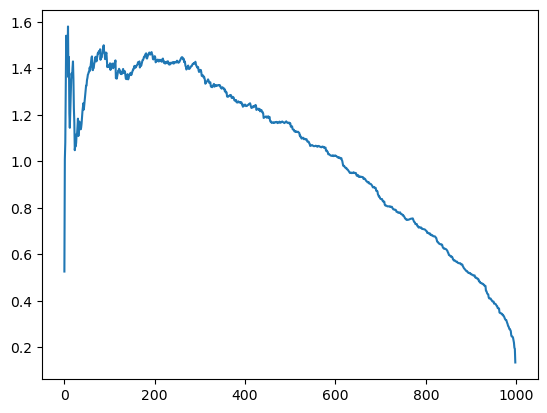

In [30]:
H = Hill_estimator(R1)
plt.plot(H)

In [35]:
xi = scipy.stats.genpareto.fit(tf.sort(R1)[950:])[0]
alpha_moments = 1/xi
print(alpha_moments)

1.6573943799753574


tf.Tensor(2.100387, shape=(), dtype=float32)
tf.Tensor(2.100387, shape=(), dtype=float32)
tf.Tensor(
[1.7249766e-03 1.8809527e-03 1.9797359e-03 ... 9.4955368e+00 1.0041738e+01
 1.1185907e+01], shape=(10000,), dtype=float32)
tf.Tensor(0.3760536, shape=(), dtype=float32)
tf.Tensor(1.0001245e-05, shape=(), dtype=float32)


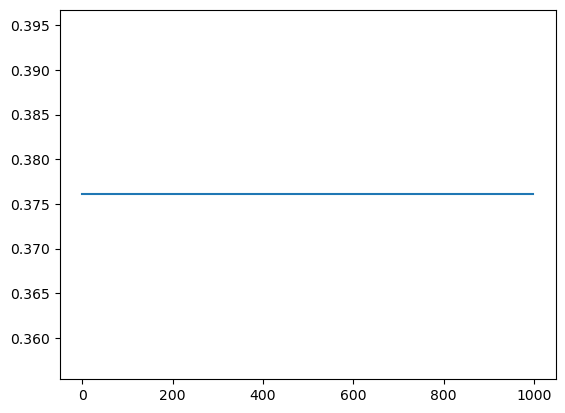

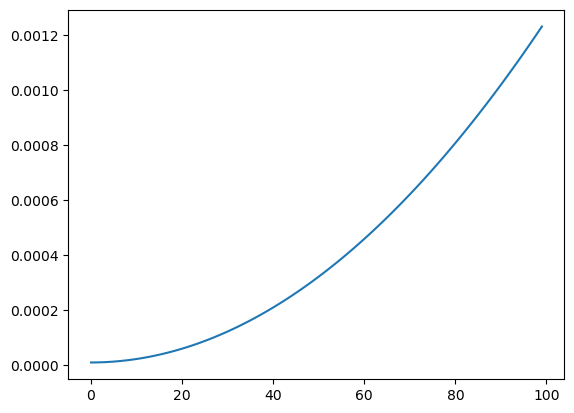

In [32]:
U = vae_test.encoder(tf.expand_dims(np.arange(1,1000,1),-1)).concentration
print(U[898])
print(U[998])
print(tf.sort(prior_samples))
c_vae = vae_test.decoder((np.arange(0.01,10,0.01,dtype = float))).concentration
print(c_vae[0])
plt.plot(c_vae)
plt.figure()
r_vae = vae_test.decoder((np.arange(0.0001,0.1,0.001,dtype = float))).rate
print(r_vae[0])
plt.plot(r_vae)

# Angle experiment

## Samples from the sphere

In [3]:
def alphas_function(x):
    res = tf.convert_to_tensor([6. -3.*tf.minimum(1.,0.5/x), 6. -3.*tf.minimum(1.,0.5/x) , 3.+ 3.*tf.minimum(1.,0.5/x), 3.+ 3.*tf.minimum(1.,0.5/x), 3.+ 3.*tf.minimum(1.,0.5/x)])
    return(tf.transpose(res))


alphas          = alphas_function(test_set)
angle_train_dep = tfd.Dirichlet(alphas).sample()

NameError: name 'test_set' is not defined

In [7]:
Ind       = tf.argsort(test_set)
R1_sort   = test_set[Ind]
angle_dep = angle_train_dep.numpy()[Ind]

## Independence between radius and angle 

In [ ]:
nbq = 100
qmax=0.01
qmin=0.3
m=60
L=200

qk = np.arange(qmax,qmin,(qmin-qmax+0.001)/nbq)
nk = 500*qk
res=[]

for i in range(nbq):
    print(i)
    pvi = 0
    q = qk[i]
    indq =int((1-q)*10000)
    n = int(nk[i])
    r = R1_sort[indq]
    print(r)
    print(q)
    Rq = R1_sort[indq:]/r
    angle = angle_dep[indq:]
    Nq = 10000-indq
    start=datetime.now()
    for k in range(m):
        IndS = tf.random.shuffle(tf.range(start=0, limit=Nq, dtype=tf.int32))[:n]
        RqS_joint = tf.gather(Rq,IndS)
        RqS_joint = tf.reshape(RqS_joint,(n,1))
        angleS_joint = tf.gather(angle,IndS)
        T_emp = T(RqS_joint,angleS_joint,int(n))
        pvk=0
        for j in range(L):
            RqS_ind=tf.random.shuffle(Rq)[:int(n)]
            RqS_ind = tf.reshape(RqS_ind,(n,1))
            angleS_ind = tf.random.shuffle(angle)[:int(n)]
            T_ind = T(RqS_ind,angleS_ind,int(n))
            pvk+= T_emp.numpy()<(T_ind.numpy())
        pvk = pvk/L
        pvi+=pvk
    print(datetime.now()-start)
    pvi = pvi/m
    res.append(pvi)
    print(qk[i])
    print(pvi)

0
12.701063
0.01
0:00:58.516064
0.01
0.53275
1
10.555375
0.01291
0:01:00.578204
0.01291
0.47050000000000003
2
8.9409685
0.01582
0:01:00.781549
0.01582
0.4230833333333334
3
8.025676
0.018729999999999997
0:01:00.844964
0.018729999999999997
0.4702500000000001
4
7.2089252
0.02164
0:01:00.852937
0.02164
0.5030833333333332
5
6.415419
0.024549999999999995
0:01:01.057911
0.024549999999999995
0.5036666666666668
6
5.8905897
0.02746
0:01:01.296883
0.02746
0.5389166666666666
7
5.490703
0.030369999999999994
0:01:02.478390
0.030369999999999994
0.47574999999999995
8
5.1781063
0.03328
0:01:04.707814
0.03328
0.5020833333333334
9
4.7861643
0.03618999999999999
0:01:06.363944
0.03618999999999999
0.5740000000000001
10
4.469511
0.039099999999999996
0:01:06.608985
0.039099999999999996
0.43891666666666646
11
4.281248
0.04201
0:01:07.420417
0.04201
0.49900000000000005
12
4.0315223
0.044919999999999995
0:01:07.687565
0.044919999999999995
0.5510833333333333
13
3.8268318
0.04782999999999999
0:01:08.547789
0.04782

## Density projected on 2 axis

In [45]:
ax0      = 3
ax1      = 4

rad      = 3
Diri_rad = tfd.Dirichlet(alphas_function(rad))

(1000,)
(1000,)


/tmp/ipykernel_83088/969063099.py:16: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([angles_x1,angles_x2])


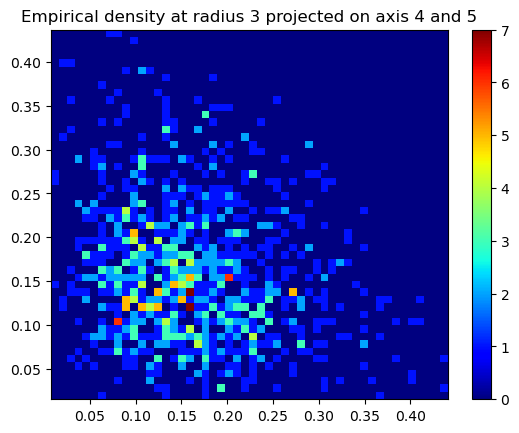

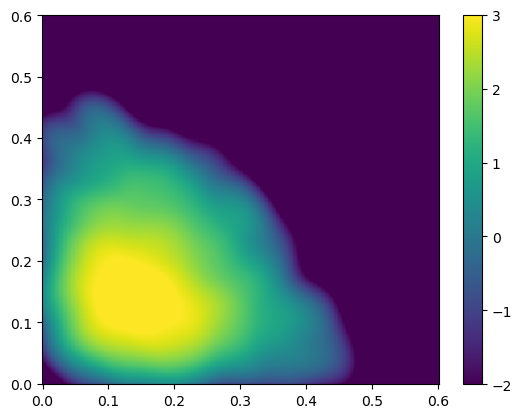

In [46]:
#plot density at given radius r  
angles    = Diri_rad.sample(1000).numpy()
angles_x1 = angles[:,ax0]
print(angles_x1.shape)
angles_x2 = angles[:,ax1]
print(angles_x2.shape)
plt.figure()
plt.title(f'Empirical density at radius {rad} projected on axis {ax0 + 1} and {ax1 + 1}')
h =plt.hist2d(angles_x1, angles_x2,bins=(50, 50), cmap=plt.cm.jet)
plt.colorbar(h[3])
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
plt.figure()

from scipy.stats import kde
nbins=300
k = kde.gaussian_kde([angles_x1,angles_x2])
xi, yi = np.mgrid[0:0.6:nbins*1j, 0:0.6:nbins*1j]
zi = np.log(k(np.vstack([xi.flatten(), yi.flatten()])))

from matplotlib.colors import Normalize
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', norm=Normalize(vmin=-2,vmax=3))
plt.colorbar()
plt.show()


## Loading model

In [39]:
checkpoint_path = '/home/nlafon/These/Extreme_VAE/tmp/sphere_radius1/diri_output/checkpoint'
import Prob_models as PM
vae_sphere = PM.Sphere_VAE()
vae_sphere.load_weights(checkpoint_path)

In [47]:
prior_samples = vae_sphere.encoder.prior.sample(1000)
angles_dist   = vae_sphere.decoder([prior_samples,rad*tf.ones((1000,1))])
angles_gen    = angles_dist.sample()
print(angles_gen.shape)
angle_gen     = angles_gen/tf.reshape(tf.reduce_sum(angles_gen,axis=1),(1000,1))

(1000, 5)


(1000,)
(1000,)


/tmp/ipykernel_83088/3730848380.py:14: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([angles_x1,angles_x2])


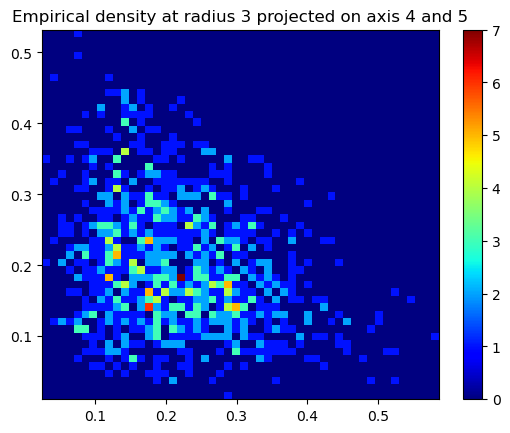

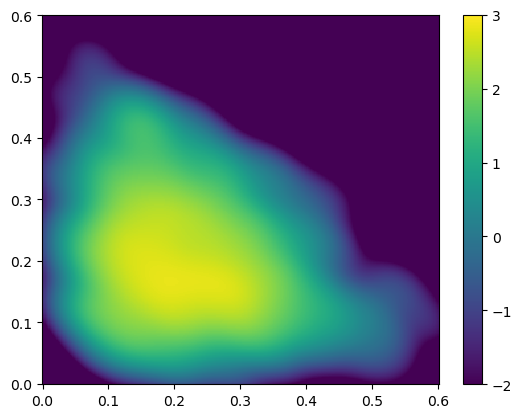

In [48]:
angles_x1 = angles_gen.numpy()[:,ax0]
print(angles_x1.shape)
angles_x2 = angles_gen.numpy()[:,ax1]
print(angles_x2.shape)
plt.figure()
plt.title(f'Empirical density at radius {rad} projected on axis {ax0 + 1} and {ax1 + 1}')
h =plt.hist2d(angles_x1, angles_x2,bins=(50, 50), cmap=plt.cm.jet)
plt.colorbar(h[3])
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
plt.figure()

from scipy.stats import kde
nbins=300
k = kde.gaussian_kde([angles_x1,angles_x2])
xi, yi = np.mgrid[0:0.6:nbins*1j, 0:0.6:nbins*1j]
zi = np.log(k(np.vstack([xi.flatten(), yi.flatten()])))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto',norm=Normalize(vmin=-2,vmax=3))
plt.colorbar()
plt.show()


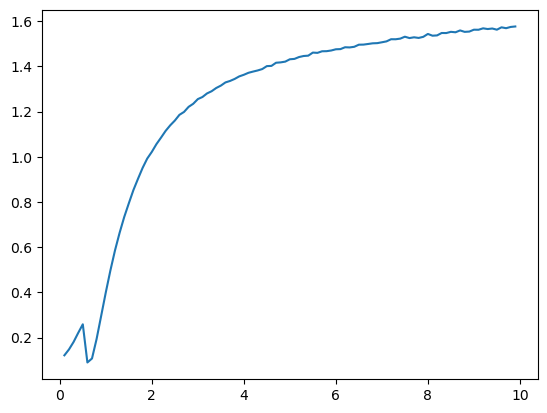

In [56]:
# KL between true angular distribution and estimated one

res   = []
R     = []
step  = 0.1
mini  = 0.1 
start = 0.1
maxi  = 10 
nstep = int((maxi-mini)/step)
r     = start

for i in range(nstep):   
    diri_true     = tfd.Dirichlet(alphas_function(r))
    prior_samples = vae_sphere.encoder.prior.sample(1000)
    angles_dist   = vae_sphere.decoder([prior_samples,r*tf.ones((1000,1))])
    kl_estimate   = tfd.kl_divergence(angles_dist, diri_true)
    res.append(tf.reduce_mean(kl_estimate))
    R.append(r)
    r            += step

plt.plot(R,res)
